
# Expression Classifier Linear NN

    Developed by: Christian Eger
    Würzburg Institute for Systems Immunology, Faculty of Medicine, Julius-Maximilian-Universität Würzburg
    Created: 240322
    Latest version: 240325



## Import Statements

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import torch.nn.functional as F

import anndata as ad
import numpy as np
import matplotlib.pyplot as plt
import helper
from tqdm import tqdm

## Data loading

In [3]:
adata = ad.read_h5ad('../data/Marburg_cell_states_locked_scANVI_ctl230901.raw.h5ad')
adata

AnnData object with n_obs × n_vars = 97573 × 27208
    obs: 'sex', 'age', 'ethnicity', 'PaCO2', 'donor', 'infection', 'disease', 'SMK', 'illumina_stimunr', 'bd_rhapsody', 'n_genes', 'doublet_scores', 'predicted_doublets', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'condition', 'sample_group', 'IAV_score', 'group', 'Viral_score', 'cell_type', 'cell_states', 'leiden', 'cell_compartment', 'seed_labels', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'mt', 'ribo'
    obsm: 'X_scANVI', 'X_scVI', 'X_umap'

## Building Pytorch Datasets from adata object and Loading them using DataLoader

In [5]:
training_size, test_size = helper.return_dataset_sizes(adata, 0.8, 0.05)

training_data, test_data, labels_map = helper.obs_to_tensor(adata, category='batch', training_size=training_size, testing_size=test_size)

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False)

In [6]:
if torch.cuda.is_available():
    num_devices = torch.cuda.device_count()
    print("Available CUDA devices:")
    for i in range(num_devices):
        print(f"  {i}: {torch.cuda.get_device_name(i)}")
    device = torch.device("cuda:1") 
    print(f"Using CUDA device: {device}")
    torch.cuda.set_device(device)
else:
    print("CUDA is not available. Using CPU.")
    device = torch.device("cpu")


Available CUDA devices:
  0: NVIDIA RTX 6000 Ada Generation
  1: NVIDIA RTX 6000 Ada Generation
Using CUDA device: cuda:1


## Model Construction

In [7]:
input_size = adata.shape[1]
num_classes = len(labels_map)

In [8]:
class GeneExpressionClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(GeneExpressionClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 400)
        self.fc2 = nn.Linear(400, 64)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Initiating Model and defining loss function and optimizer

In [9]:
model = GeneExpressionClassifier(input_size, num_classes)
model.to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.000001, momentum=0.9)

## Training Loop

In [11]:
num_epochs = 1000 
train_losses, val_losses = [], []

for i in tqdm(range(num_epochs)):
    model.train()
    running_loss = 0.0
    for expression, label in train_dataloader:
        expression, label = expression.to(device), label.to(device)
        optimizer.zero_grad()
        output = model(expression)
        loss = loss_fn(output, label)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() / expression.size(0)
    train_loss = running_loss / len(train_dataloader.dataset)
    train_losses.append(train_loss)
        # Validation phase
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for expression, label in test_dataloader:
            # Move inputs and labels to the device
            expression, label = expression.to(device), label.to(device)
            outputs = model(expression)
            loss = loss_fn(outputs, label)
            running_loss += loss.item() * label.size(0)
    val_loss = running_loss / len(test_dataloader.dataset)
    val_losses.append(val_loss)
    #print(f"Epoch {i+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}")

100%|██████████| 1000/1000 [01:51<00:00,  8.95it/s]


In [12]:
model.to('cpu')
helper.evaluate_model(model, training_data, labels_map)
helper.evaluate_model(model, test_data, labels_map)

The models accuracy is 96.56674353061747%
The accuracy of random classification would be 4.166666666666666%
The models accuracy is 72.54098360655738%
The accuracy of random classification would be 4.166666666666666%


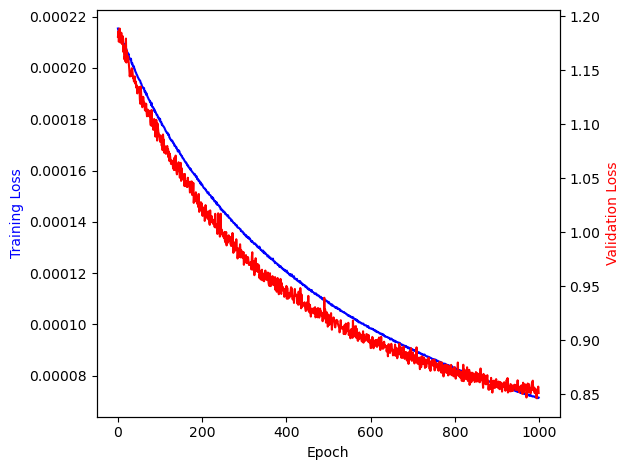

In [13]:
helper.plot_scaled_losses(train_losses, val_losses, num_epochs)

In [14]:
#torch.save(model.state_dict(), 'weights_Expression_Classifier.pth')